## Function for Bai and Perron method

Readme:
- we use **ruptures** library to detect change points by Bai and Perron method.
    - [Install ](https://centre-borelli.github.io/ruptures-docs/install/) and [Tutorial](https://centre-borelli.github.io/ruptures-docs/user-guide/costs/costlinear/)
- However, ruptures only provides the location of change points and residuals sum of squared given the number of change points
- Hence, we make some codes for caluclating BIC to choose the best number of change points.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt
import statsmodels.api as sm

def function_bai_perron(Y, X, max_cp, min_seg_size = 30):
    # Input:
    # Y: a vector for the objective variable
    # X: (# of samples * # of predictors) matrix for predictors. if you consider a regression model with constant, you should include it in X matrix.
    # max_cp: the maximal number of change points that this function will seach
    # min_seg_size: the minimal number of obsevations in each segment.
    
    # output:
    # optimal_number: the optimal number of change points. It minimise the BIC
    # optimal_location: the optimal lcoations for the optimal number of change points
    # RESULT: the obtained solution for the location of change points for each number of change points
    # RSS: the computed residual sum of squared for each number of change points
    # BIC: the computed value of BIC for each number of change points
    # range_of_change_points: the range of change points that this function has searched.
    
    # matrix [Y, X]
    matrix = np.c_[Y, X]
    
    # list for results
    RSS = []
    BIC = []
    LOCATION = []
    
    # Given the number of change points, the locations of change points are estimated.
    for i in range(max_cp + 1):
        # fitting 
        algo = rpt.Dynp(model="linear", min_size = min_seg_size, jump = 1).fit(matrix)
        
        # locations of change points given the number of change points:
        result = algo.predict(i)
        
        # Residuals Sum of Squared
        cost = rpt.costs.CostLinear().fit(matrix)
        rss = cost.sum_of_costs(result)
        
        # compute BIC
        n_obs = len(Y)
        
        # calculate degree of freedom to compute BIC
        n_coeff = X.shape[1] # the number of coefficients
        n_seg = len(result) # the number of segments that is equivalent to 1 + the number of change points
        degree_of_freedom = n_coeff*n_seg + 1 + n_seg -1# n_coeff*n_seg + 1 is degree of freedom for the regression model, n_seg -1 is the number of change points that can be also degree of freedom
        
        # calculate the log-likelihood
        # When we have change points, we formulate the regression model by indicator function.
        # Hence we can estimate single regression model even though we have multiple change points
        if n_seg == 1:
            log_likelihood = sm.OLS(matrix[0:result[0], 0], matrix[0:result[0], 1:]).fit().llf
        else:
            matrix_for_hadamard_product = np.zeros((n_obs, n_coeff))
            matrix_for_hadamard_product[0:result[0],:] = 1
            matrix_X = np.multiply(X, matrix_for_hadamard_product)
            for j in range(n_seg-1):
                matrix_for_hadamard_product = np.zeros((n_obs, n_coeff))
                matrix_for_hadamard_product[result[j]:result[j+1],:] = 1
                temp = np.multiply(X, matrix_for_hadamard_product)
                matrix_X = np.c_[matrix_X, temp]
            
            log_likelihood = sm.OLS(matrix[:, 0], matrix_X).fit().llf
                              
        print(f'The number of change points: {i}')
        print(f'log likelihood: {log_likelihood}')
        print(f'degree of freedom: {degree_of_freedom}')
        
        # BIC = degree of freedom*log(# of samples) - 2 * log lilkelihood
        bic = degree_of_freedom*np.log(n_obs)- 2*(log_likelihood)
        
        print(f'BIC: {bic}')
        print(f'RSS: {rss}')
        
        print("----------------------")
        
        #bic = n_obs*np.log(rss/n_obs) + degree_of_freedom*np.log(n_obs)

        # save the result
        LOCATION.append(result)
        RSS.append(rss)
        BIC.append(bic)
    
    # best change point
    optimal_number = BIC.index(min(BIC))
    optimal_location = LOCATION[optimal_number]
    range_of_change_points = list(range(max_cp + 1))
    
    print("--------------------------")
    print("--------------------------")
    print(f'the optimal number of chnage points: {optimal_number}')
    print(f'their locations:  {optimal_location}')

    return(optimal_number, optimal_location, LOCATION, RSS, BIC, range_of_change_points)

### check how the fucntion works using the same data as R

- the obtained locations and residuals sum of squares given the number of change points are consistent.
- However, the calculated BIC is close to the one in R, but they are slightly different. R mannual and the papers does not mention the exact way to compute BIC.

In [2]:
mat_simulated = pd.read_csv("simulation_data_R.csv").values
sol_number, sol_location, location,residuals_sum_of_square, bic, range_cp = function_bai_perron(mat_simulated[:, 0], mat_simulated[:, 1:], 5)

The number of change points: 0
log likelihood: -404.9138288072506
degree of freedom: 7
BIC: 846.9158791803375
RSS: 671.5433616644332
----------------------
The number of change points: 1
log likelihood: -280.9143482680014
degree of freedom: 14
BIC: 636.0051396676753
RSS: 194.33506001916288
----------------------
The number of change points: 2
log likelihood: -275.1692955614669
degree of freedom: 21
BIC: 661.6032558204427
RSS: 183.48506155356878
----------------------
The number of change points: 3
log likelihood: -271.57364902519515
degree of freedom: 28
BIC: 691.5001843137353
RSS: 177.00478929836973
----------------------
The number of change points: 4
log likelihood: -268.61920250901585
degree of freedom: 35
BIC: 722.679512847213
RSS: 171.85177383334195
----------------------
The number of change points: 5
log likelihood: -267.386555480383
degree of freedom: 42
BIC: 757.3024403557835
RSS: 169.74645031062053
----------------------
--------------------------
--------------------------


In [3]:
print("optimal number of change points: ", str(sol_number))
print("optimal locations of change points: ", str(sol_location))

optimal number of change points:  1
optimal locations of change points:  [100, 200]


In [4]:
location

[[200],
 [100, 200],
 [42, 100, 200],
 [42, 100, 166, 200],
 [42, 97, 127, 159, 200],
 [40, 70, 100, 139, 169, 200]]

In [5]:
residuals_sum_of_square

[671.5433616644332,
 194.33506001916288,
 183.48506155356878,
 177.00478929836973,
 171.85177383334195,
 169.74645031062053]

In [6]:
bic

[846.9158791803375,
 636.0051396676753,
 661.6032558204427,
 691.5001843137353,
 722.679512847213,
 757.3024403557835]

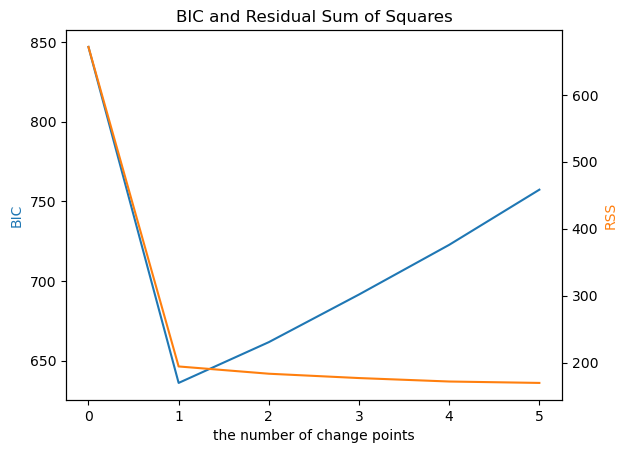

In [7]:
fig,ax = plt.subplots()

# BIC
ax.plot(range_cp, bic, color="#1f77b4")
ax.set_xlabel("the number of change points")
ax.set_ylabel("BIC", color="#1f77b4")
# RSS
ax2=ax.twinx()
ax2.plot(range_cp, residuals_sum_of_square,color="#ff7f0e")
ax2.set_ylabel("RSS",color="#ff7f0e")

plt.title("BIC and Residual Sum of Squares")
plt.show()